# Eine fiktive Milonga

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Milonga.ipynb)

In einer Milonga gibt es 7 Männer und 5 Frauen. Die Teilnehmer kennen sich alle untereinander und haben bestimmte Präferenzen für Tanzpartner, die in dem Datensatz `dance` beschrieben sind. Finden Sie die beste Zuordnung von Tanzpaaren, so die Gesamtzufriedenheit aller Paare maximal ist (gemessen als die Summe der erfühlten Präferenzen).

In [ ]:
%pip install gurobipy

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

Note: you may need to restart the kernel to use updated packages.


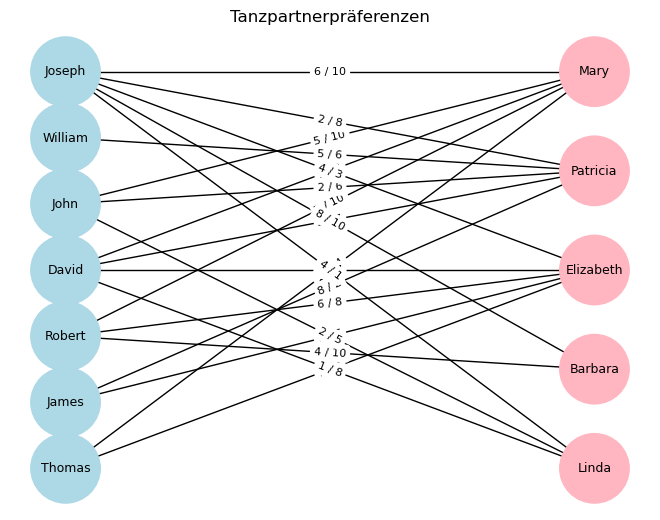

In [25]:
#| label: fig-milonga
#| fig-cap: Tanzpartnerpräferenzen

random.seed(122)

# Generate random names for men and women
male_names = ["John", "Michael", "David", "James", "Robert", "William", "Joseph", "Charles", "Thomas"]
female_names = ["Mary", "Patricia", "Jennifer", "Linda", "Elizabeth", "Barbara", "Susan"]

# Create a bipartite graph
B = nx.Graph()

men_n = 7
women_n = 5

# Add nodes for men and women
men = random.sample(male_names, men_n)  # Randomly select 7 male names
women = random.sample(female_names, women_n)  # Randomly select 5 female names

B.add_nodes_from(men, bipartite=0)  # Add men to one set
B.add_nodes_from(women, bipartite=1)  # Add women to the other set

# Ensure every man is connected to at least one woman
edges = [(man, random.choice(women)) for man in men]

# Ensure every woman is connected to at least one man
edges += [(random.choice(men), woman) for woman in women]

# Add additional random edges to make the graph more connected
additional_edges = [
    (random.choice(men), random.choice(women)) for _ in range(men_n + women_n - 1)
]
edges += additional_edges

# Add edges to the graph with two sets of random weights
for edge in edges:
    B.add_edge(edge[0], edge[1], mPref=random.randint(1, 10), wPref=random.randint(1, 10))  # Assign two random weights

# Draw the bipartite graph
pos = nx.drawing.layout.bipartite_layout(B, men)  # Position nodes in two layers
nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=["lightblue" if node in men else "lightpink" for node in B.nodes()],
    node_size=2500,  # Increase node size to fit names
    font_size=9  # Reduce font size of the names
)

# Draw edge labels to show both preferences
edge_labels = nx.get_edge_attributes(B, 'mPref')
edge_labels2 = nx.get_edge_attributes(B, 'wPref')

# Combine both weights into a single label for display
combined_labels = {edge: f"{edge_labels[edge]} / {edge_labels2[edge]}" for edge in edge_labels}
nx.draw_networkx_edge_labels(B, pos, edge_labels=combined_labels, font_size=8)

plt.title("Tanzpartnerpräferenzen")
plt.show()

Unsere Aufgabe hier ist es, die Tanzpartner so zuzuordnen, dass die Gesamtzufriedenheit aller Paare maximal ist.

Der Datensatz `dt` enthält die Präferenzen der Männer und der Frauen. Der Index des Datensatzes ist zwei-dimensional, wobei die erste Dimension den Namen des Mannes und die zweite Dimension den Namen der Frau enthält. Die Spalten `wPref` und `mPref` enthalten die Präferenzen der Frauen und der Männer

In [ ]:
# Convert the graph to a pandas dataframe

dt = nx.to_pandas_edgelist(B).rename(columns = {"source": "man", "target": "woman"})
dt.set_index(["man", "woman"], inplace = True)
# Display the dataframe

dt["pref"] = dt["mPref"] + dt["wPref"]
dt

wPref  mPref  pref
men     women                        
Thomas  Elizabeth      2      7     9
        Mary           4     10    14
James   Patricia       2      8    10
        Elizabeth      6      6    12
Robert  Barbara       10      4    14
        Elizabeth      8      6    14
        Mary          10      7    17
David   Mary           4      1     5
        Linda          8      1     9
        Elizabeth      4      9    13
        Patricia       7      3    10
John    Patricia       6      2     8
        Linda          5      2     7
        Mary          10      5    15
William Patricia       6      5    11
Joseph  Barbara       10      8    18
        Linda          1      4     5
        Patricia       8      2    10
        Mary          10      6    16
        Elizabeth      3      4     7

## Das Modell

## Mengen

$i \in M = \{1, \ldots, 7\}$: Menge der Männer

$j \in W = \{1, \ldots, 5\}$: Menge der Frauen

## Parameter

$\text{pMen}_{ij} \in \mathbb{R}$: Präferenz des Mannes $i$ für die Frau $j$

$\text{pWomen}_{ij} \in \mathbb{R}$: Präferenz der Frau $j$ für den Mann $i$

## Variablen

$\text{pair}_{ij} \in \{0, 1\}$: 1, falls Mann $i$ mit Frau $j$ ein Paar bildet, 0 sonst

## Zielsetzung

\begin{equation}
\max \sum_{i \in M} \sum_{j \in W} (\text{pMan}_{ij} + \text{pWoman}_{ij}  ) \cdot \text{pair}_{ij}
\end{equation}

## Nebenbedingungen

Jeder Man bildet ein Paar mit höchstens einer Frau:

\begin{equation}
\sum_{j \in W} \text{pair}_{ij} \leq 1 \quad \forall i \in M
\end{equation}

Jede Frau bildet ein Paar mit höchstens einem Mann:

\begin{equation}
\sum_{i \in M} \text{pair}_{ij} \leq 1 \quad \forall j \in W
\end{equation}





In [18]:
dt.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [19]:
dt.index.levels[1]

Index(['Barbara', 'Elizabeth', 'Linda', 'Mary', 'Patricia'], dtype='object', name='women')

In [20]:
dt.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [21]:
# import gurobipy as gp
# from gurobipy import GRB

# m = gp.Model('Tanzpaare')
# # m.Params.LogToConsole = 0

# # Create variables

# x = m.addVars(dt.index, vtype=GRB.BINARY, name="pair")

# # Zielfunktion

# m.setObjective(..., GRB.MAXIMIZE)

# # Jeder Mann wird höchstens einer Frau zugewiesen

# c_men = m.addConstrs((x.sum(man, '*') <= 1 for man in dt.index.levels[0]), name="Mann")

# c_women = m.addConstrs(..., name="Frau")

# m.optimize()

In [22]:
# # Lösung ausgeben als pandas DataFrame

# solution = pd.DataFrame(columns=["Paar"], index=dt.index)
# for pair in x.keys():
#     if x[pair].x > 0.5:
#         solution.loc[pair] = 1
#     else:
#         solution.loc[pair] = 0

# solution["Paar"].sum()

In [ ]:
# sol = solution.reset_index()

# sol["IsDancing"] = sol.groupby("man")["Paar"].transform("sum")
# sol[sol["IsDancing"] == 0]["man"].unique()

In [24]:
# m.write('Tanzpaare.lp')

# with open('Tanzpaare.lp', 'r') as f:
#     print(f.read())
